<a href="https://colab.research.google.com/github/cij1012/3-min-pytorch/blob/main/5.1%20Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
Epochs = 300
Batch_size = 128

In [4]:
# CIFAR10 데이터셋   32 * 32 * 3(RGB)의 이미지 6만개이상

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=Batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5),
                                            (0.5, 0.5, 0.5))])),
    batch_size=Batch_size, shuffle=True)

Extracting ./.data/cifar-10-python.tar.gz to ./.data


In [5]:

learning_rate = 0.0005
training_epochs = 50
batch_size = 256

In [6]:
cifar10_train = datasets.CIFAR10(root='cifar10/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

cifar10_test = datasets.CIFAR10(root='cifar10/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

Extracting cifar10/cifar-10-python.tar.gz to cifar10/
Files already downloaded and verified


In [7]:
data_loader = torch.utils.data.DataLoader(dataset=cifar10_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


In [8]:
# Gradient Vanishing

class SHALLOW_CNN(nn.Module):
  def __init__(self):
    super(SHALLOW_CNN, self).__init__()
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc = torch.nn.Linear(8 * 8 * 64, 10, bias=True)
    torch.nn.init.xavier_uniform_(self.fc.weight)
    
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out

In [9]:
class CNN(torch.nn.Module):

    def __init__(self,num_layers):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        self.layers = []
        for _ in range(num_layers):
            self.layers.append(torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
            self.layers.append(torch.nn.ReLU())
        self.layers = torch.nn.Sequential(*self.layers)
        
        self.fc = torch.nn.Linear(5 * 5 * 128, 10)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layers(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [10]:
shallow_model = CNN(4).to(device)
deep_model = CNN(12).to(device)

In [11]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(shallow_model.parameters(), lr=learning_rate)

In [12]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))


총 배치의 수 : 195


In [13]:
shallow_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = shallow_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    shallow_costs.append(avg_cost)
    if epoch%10==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 1.86805093
[Epoch:   11] cost = 0.605716646
[Epoch:   21] cost = 0.162683681
[Epoch:   31] cost = 0.0625224337
[Epoch:   41] cost = 0.0573107488


In [14]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(deep_model.parameters(), lr=learning_rate)

In [15]:
deep_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = deep_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    deep_costs.append(avg_cost)
    if epoch%10==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 2.20142794
[Epoch:   11] cost = 0.745410621
[Epoch:   21] cost = 0.302573532
[Epoch:   31] cost = 0.115973905
[Epoch:   41] cost = 0.0795913562


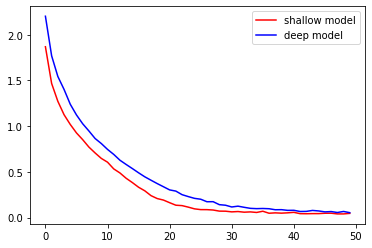

In [16]:
import matplotlib.pyplot as plt

plt.plot(shallow_costs, label = "shallow model",c='r')
plt.plot(deep_costs, label = "deep model",c='b')
plt.legend()
plt.show()

In [23]:
def conv3x3(in_channels, out_channels, stride=1):
  return torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = stride, padding=1, bias=False)

#Residual Block
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(ResidualBlock, self).__init__()
    self.conv1 = conv3x3(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample:
      residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out
  
# ResNet
class ResNet(torch.nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = torch.nn.BatchNorm2d(16)
        self.relu = torch.nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = torch.nn.AvgPool2d(8)
        self.fc = torch.nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = torch.nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                torch.nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [24]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
resnet_costs = []
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    resnet_costs.append(avg_cost)
    if epoch%5==0:
        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 1.49122405
[Epoch:    6] cost = 0.636931717
[Epoch:   11] cost = 0.397835225
[Epoch:   16] cost = 0.229356036
[Epoch:   21] cost = 0.126574591
[Epoch:   26] cost = 0.0879853442
[Epoch:   31] cost = 0.063843362
[Epoch:   36] cost = 0.0522136614
[Epoch:   41] cost = 0.0620435514
[Epoch:   46] cost = 0.0456955358
